# Diabetes Readmission modelling using Random Forests

In [0]:
# Data processing
from pyspark.sql.functions import log, col, exp

# Modeling
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [0]:
diabetes_readmit = spark.read.table("diab_readmit_csv")
write_path = 'dbfs:/tmp/reproducible_ml_uofl/diab_readmit_csv.delta'
diabetes_readmit.write.format('delta').mode('overwrite').save(write_path)

In [0]:
diabetes_readmit = spark.read.format('delta').load(write_path)

#Show basic summary stats
display(diabetes_readmit.summary())

summary,patient_nbr,time_in_hospital,num_procedures,num_lab_procedures,num_medications,number_outpatient,number_inpatient,number_emergency,number_diagnoses,gender_cd,DiabetesMedication,readmit_flag,race_cd
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
mean,5.4330400694947235E7,4.395986871843248,1.339730361810428,43.09564098028811,16.021844230882614,0.36935715268360747,0.635565906098304,0.19783621248747127,7.422606764538254,0.5375862272271682,0.7700312481575379,0.11159915885462728,null
stddev,3.869635934653421E7,2.985107767471267,1.705806979121172,19.674362249142096,8.127566209167309,1.2672650965326817,1.26286329009732,0.9304722684224632,1.9336001449974247,0.49858772375671534,0.420814525814695,0.3148741984505526,null
min,135,1,0,1,1,0,0,0,1,0,0,0,AfrAmr
25%,23412645,2,0,31,10,0,0,0,6,0,1,0,null
50%,45500490,4,1,44,15,0,0,0,8,1,1,0,null
75%,87532902,6,2,57,20,0,1,0,9,1,1,0,null
max,189502619,14,6,132,81,42,21,76,16,1,1,1,White


In [0]:
# Train test split
trainDF, testDF = diabetes_readmit.randomSplit([.65, .35], seed=42)
# Print the number of records
print(f'There are {trainDF.cache().count()} records in the training dataset.')
print(f'There are {testDF.cache().count()} records in the testing dataset.')

There are 66284 records in the training dataset.
There are 35482 records in the testing dataset.

##Now we need to modify the categorical variable race_cd into one-hot-encoded version
 For this we can either use the StringIndexer and OneHotEncoder separately OR use a pipeline to do this in one step

In [0]:
#You can also create a pipeline and do everything together in one easy fit and transform step
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
 
categoricalColumns = ["race_cd"]
stages = [] # stages in Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    
# Use OneHotEncoder to convert categorical variables into binary SparseVectors
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

# Define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages=[stringIndexer, encoder])
 
# Define the pipeline model.
transform_mdl = pipeline.fit(trainDF)
trainDF21=transform_mdl.transform(trainDF)
trainDF21.show()

+-----------+----------------+--------------+------------------+---------------+-----------------+----------------+----------------+----------------+---------+------------------+------------+-------+------------+---------------+
patient_nbr|time_in_hospital|num_procedures|num_lab_procedures|num_medications|number_outpatient|number_inpatient|number_emergency|number_diagnoses|gender_cd|DiabetesMedication|readmit_flag|race_cd|race_cdIndex|race_cdclassVec|
+-----------+----------------+--------------+------------------+---------------+-----------------+----------------+----------------+----------------+---------+------------------+------------+-------+------------+---------------+
 135| 3| 1| 31| 14| 0| 1| 0| 5| 1| 1| 0| White| 0.0| (4,[0],[1.0])|
 135| 8| 6| 77| 33| 0| 0| 0| 8| 1| 1| 1| White| 0.0| (4,[0],[1.0])|
 729| 4| 2| 68| 23| 0| 0| 0| 9| 1| 1| 0| White| 0.0| (4,[0],[1.0])|
 927| 5| 0| 49| 5| 0| 0| 0| 3| 1| 1| 0| AfrAmr| 1.0| (4,[1],[1.0])|
 1152| 6| 4| 45| 15| 0| 2| 0| 6| 1| 1| 0| AfrAmr| 1.0| (4,[1],[1.0])|
 1152| 12| 1| 37| 18| 0| 2| 0| 5| 1| 1| 0| AfrAmr| 1.0| (4,[1],[1.0])|
 1314| 1| 5| 47| 12| 0| 1| 0| 7| 1| 1| 1| White| 0.0| (4,[0],[1.0])|
 2025| 12| 2| 47| 18| 0| 0| 0| 9| 1| 1| 0| White| 0.0| (4,[0],[1.0])|
 3069| 8| 6| 57| 31| 0| 0| 0| 9| 0| 1| 0| White| 0.0| (4,[0],[1.0])|
 4302| 1| 1| 31| 9| 0| 0| 0| 7| 1| 0| 0| White| 0.0| (4,[0],[1.0])|
 5220| 2| 0| 15| 14| 0| 0| 0| 9| 0| 1| 0| White| 0.0| (4,[0],[1.0])|
 5220| 11| 4| 65| 19| 0| 2| 0| 9| 0| 1| 0| White| 0.0| (4,[0],[1.0])|
 6174| 7| 0| 77| 12| 0| 0| 0| 9| 1| 1| 0| White| 0.0| (4,[0],[1.0])|
 6228| 4| 4| 47| 16| 0| 0| 0| 7| 1| 0| 0| White| 0.0| (4,[0],[1.0])|
 6309| 1| 5| 35| 13| 0| 0| 0| 8| 0| 1| 0| White| 0.0| (4,[0],[1.0])|
 6939| 6| 2| 65| 19| 0| 0| 0| 7| 0| 1| 0| White| 0.0| (4,[0],[1.0])|
 8154| 1| 0| 58| 5| 0| 0| 0| 8| 1| 0| 0| White| 0.0| (4,[0],[1.0])|
 8748| 2| 0| 64| 10| 0| 0| 0| 9| 0| 1| 0| AfrAmr| 1.0| (4,[1],[1.0])|
 10377| 1| 2| 33| 12| 0| 0| 0| 5| 0| 1| 0| White| 0.0| (4,[0],[1.0])|
 10422| 4| 2| 54| 3| 0| 0| 0| 8| 1| 0| 0| AfrAmr| 1.0| (4,[1],[1.0])|
+-----------+----------------+--------------+------------------+---------------+-----------------+----------------+----------------+----------------+---------+------------------+------------+-------+------------+---------------+
only showing top 20 rows

In [0]:
# Linear regression expect a vector input
vecAssembler = VectorAssembler(inputCols=['time_in_hospital','num_procedures','num_medications', 'number_inpatient','number_emergency','number_diagnoses','DiabetesMedication'], outputCol="features")
vecTrainDF = vecAssembler.transform(trainDF21)

In [0]:
# Create Random Forest calssifier
rf = RandomForestClassifier(featuresCol="features", labelCol="readmit_flag", numTrees=50)
rfModel = rf.fit(vecTrainDF)
predict_train = rfModel.transform(vecTrainDF)
predict_train.select('readmit_flag', 'rawPrediction', 'prediction', 'probability').show(10)


+------------+--------------------+----------+--------------------+
readmit_flag| rawPrediction|prediction| probability|
+------------+--------------------+----------+--------------------+
 0|[45.1621604034091...| 0.0|[0.90324320806818...|
 1|[44.8170339740043...| 0.0|[0.89634067948008...|
 0|[45.0274724761577...| 0.0|[0.90054944952315...|
 0|[45.4902188723566...| 0.0|[0.90980437744713...|
 0|[41.6154951998464...| 0.0|[0.83230990399692...|
 0|[42.1094719413568...| 0.0|[0.84218943882713...|
 1|[45.0707526257579...| 0.0|[0.90141505251515...|
 0|[44.8170339740043...| 0.0|[0.89634067948008...|
 0|[44.8170339740043...| 0.0|[0.89634067948008...|
 0|[45.413965521092,...| 0.0|[0.90827931042184...|
+------------+--------------------+----------+--------------------+
only showing top 10 rows

In [0]:
testDF21=transform_mdl.transform(testDF) #do the data transformation using saved parameters from training
vecTestDF = vecAssembler.transform(testDF21) #do the feature transformation using vector assembler
# Make predictions on testing dataset
predict_test = rfModel.transform(vecTestDF) #make predictions using the trained model

In [0]:
eval_rf = BinaryClassificationEvaluator(labelCol = "readmit_flag")
auc_train = eval_rf.evaluate(predict_train)
print(auc_train)

auc_test = eval_rf.evaluate(predict_test)
print(auc_test)

0.6302647713638008
0.6290623407840733

In [0]:
import pandas as pd
import time 
import sys
from pyspark.sql.window import *
from pyspark.sql.types import * 
from pyspark.sql.functions import *
import pyspark.sql.functions as f

def get_model_stats(print_lable,dataset,evaluator,mbr_id,target):
  print(print_lable)
  AUROC=evaluator.evaluate(dataset)
  
  tot_event=dataset.count()
  tot_target=dataset.select(target).filter(f.col(target)==1).count()
  inc_rate=float(tot_target)/float(tot_event)
  print('Incidence rate in dataset: ',inc_rate)
  print('AUROC: ',AUROC)
  

  def mbr_prob1(prob_vec):
    return float(prob_vec[1]) #Get the second value from probability vector of the prediction since that is probability of target 1
  def mbr_prob2(rawp_vec):
    prob_vec = np.exp(rawp_vector)/(1+ np.exp(rawp_vec)) #this is the same as the logit function e**x/1+e**x
    return float(prob_vec[1])
  get_prob_1= udf(mbr_prob1, FloatType())
  get_prob_2= udf(mbr_prob2, FloatType())

  try:
    df_plot_tmp = dataset.withColumn('prob_score', get_prob_1('probability'))
  except:
    df_plot_tmp = dataset.withColumn('prob_score', get_prob_2('rawPrediction'))
  df_reg1=(df_plot_tmp.select(mbr_id,"rawPrediction","probability","prob_score",target))

  #Create Percentiles based on the predicted probability
  df_reg_12=  df_reg1.sort(col("prob_score").desc())
  df_reg_12 = df_reg_12.withColumn("new_column",lit("ABC"))
  w = Window().partitionBy("new_column").orderBy(col("prob_score").desc())  
  df_reg_12 = df_reg_12.withColumn("row_num",row_number().over(w)).drop("new_column")
  df_reg2 = (df_reg_12
             .withColumn("score_pctl", f.percent_rank().over(Window.orderBy(f.col("row_num"))))
             .withColumn("pctl_cat", f.when(f.col("score_pctl")==1, f.lit(100)).otherwise(f.floor(f.col("score_pctl")*100) + 1))
             )
  df_reg22 = (df_reg2
              .groupBy("pctl_cat")
              .agg(f.mean(target).alias("pctl_target_rate"),\
                   (f.sum(target)).alias("pctl_target_total"),\
                   (f.count(mbr_id)).alias("total_count"),\
                   (f.mean("prob_score")).alias("mean_predicted_prob")
                  ,)
              .orderBy(f.col("pctl_cat"))
              )

  #Now let's create the cumulative percentiles
  cum_sum = (df_reg22
              .withColumn('cum_target', f.sum(df_reg22.pctl_target_total).over(Window.partitionBy().orderBy().rowsBetween(-sys.maxsize, 0)))
              .withColumn('cum_total', f.sum(df_reg22.total_count).over(Window.partitionBy().orderBy().rowsBetween(-sys.maxsize, 0)))
              .withColumn('cum_target_cap_rate',f.col("cum_target")/f.col("cum_total"))
              .withColumn('cum_target_cap_of_total',((f.col("cum_target")/tot_target))*100)
            )
  return cum_sum

In [0]:
cum_cap_dt = get_model_stats("Decision Tree",predict_test,eval_rf,"patient_nbr","readmit_flag")

Decision Tree
Incidence rate in dataset: 0.11225410067076264
AUROC: 0.6290623407840733

In [0]:
display(cum_cap_dt)

pctl_cat,pctl_target_rate,pctl_target_total,total_count,mean_predicted_prob,cum_target,cum_total,cum_target_cap_rate,cum_target_cap_of_total
1,0.447887323943662,159,355,0.3090801333877402,159,355,0.447887323943662,3.991965854883254
2,0.28450704225352114,101,355,0.23989384610887984,260,710,0.36619718309859156,6.527742907356264
3,0.24507042253521127,87,355,0.19554336755208565,347,1065,0.32582159624413143,8.71202611097163
4,0.2140845070422535,76,355,0.17967137719543888,423,1420,0.29788732394366196,10.620135576198846
5,0.24225352112676057,86,355,0.17561582192568712,509,1775,0.28676056338028166,12.779312076324379
6,0.16101694915254236,57,354,0.17171915982571026,566,2129,0.26585251291686235,14.21039417524479
7,0.19718309859154928,70,355,0.1687989012036525,636,2484,0.2560386473429952,15.967863419533016
8,0.2,71,355,0.16699962338931124,707,2839,0.24903134906657273,17.75043936731107
9,0.17464788732394365,62,355,0.16590149192742898,769,3194,0.24076393237319976,19.307054983680644
10,0.21690140845070421,77,355,0.16506076253635782,846,3549,0.23837700760777683,21.240271152397693


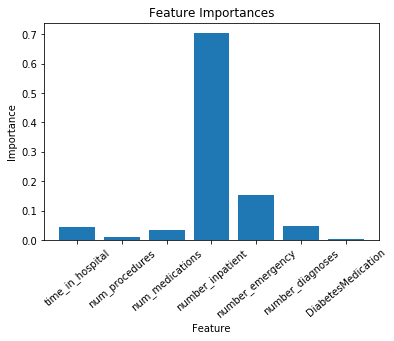

In [0]:
import matplotlib.pyplot as plt 
feat_imps=rfModel.featureImportances
x_values = list(range(len(feat_imps)))
plt.bar(x_values, feat_imps, orientation = 'vertical')
plt.xticks(x_values, ['time_in_hospital','num_procedures','num_medications', 'number_inpatient','number_emergency','number_diagnoses','DiabetesMedication'], rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')